In [22]:
import tensorflow as tf
from tensorflow.keras.metrics import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from hausdorff import hausdorff_distance
#import lr_scheduler
from tensorflow.keras.regularizers import l2

import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.morphology import label
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

In [23]:
TRAIN_PATH="DRIVE/training/"
TEST_PATH="DRIVE/test/"

In [24]:
train_ids=next(os.walk(TRAIN_PATH+'images/'))[2][:]
test_ids=next(os.walk(TEST_PATH+'images/'))[2][:]
print(len(train_ids))

20


In [25]:
input_height = IMG_HEIGHT = 256
input_width = IMG_WIDTH = 256
IMG_CHANNELS = 3

In [26]:

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TRAIN_PATH + 'mask/' + id_[:-4] + '_mask.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_train[n][mask > 0.] = 1.

print('Resizing test images and masks')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):   
    path = TEST_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TEST_PATH + 'mask/' + id_[:-4] + '_mask.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_test[n][mask > 0.] = 1.

Resizing training images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\manda\AppData\Local\Temp\ipykernel_26836\727015007.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.21it/s]


Resizing test images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\manda\AppData\Local\Temp\ipykernel_26836\727015007.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.06it/s]


In [27]:
print(X_train.shape, Y_test.shape)

(20, 256, 256, 3) (20, 256, 256, 1)


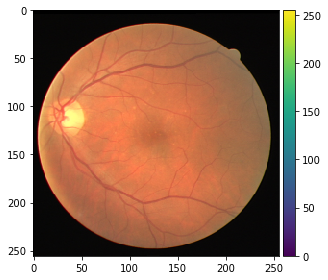

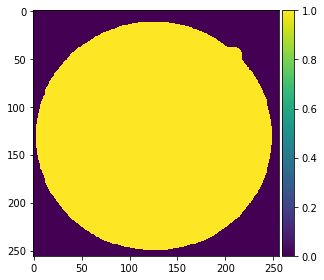

In [28]:
ix=0
imshow(X_train[ix].astype('int'))
plt.show()
imshow(np.squeeze(Y_train[ix].astype('int')))
plt.show()

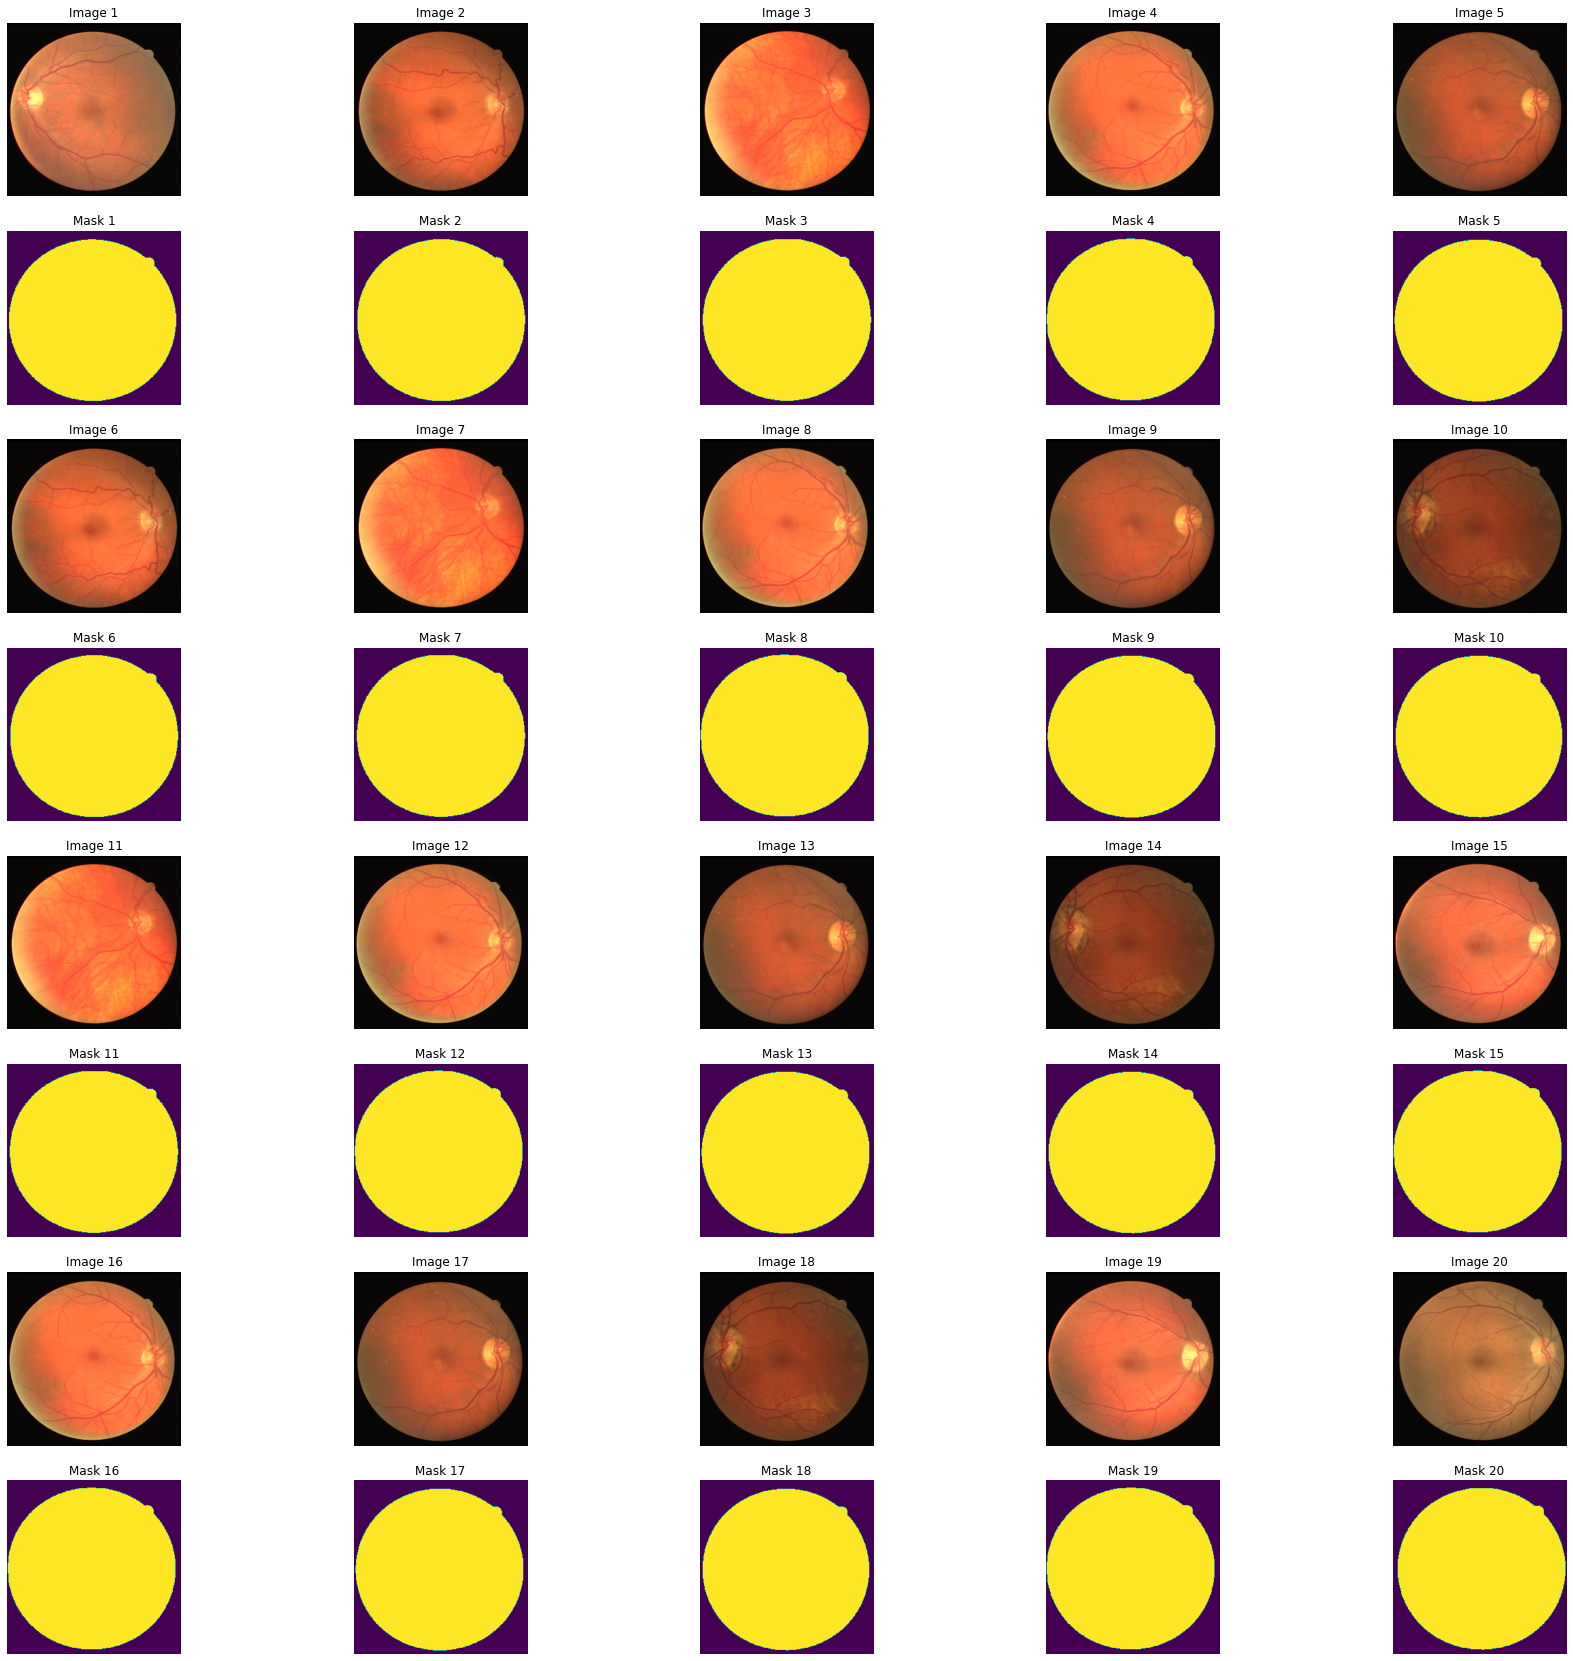

In [29]:
plt.figure(figsize=(30,30))
x, y = 5, 4
count=1
for i in range(y):
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i+j
        plt.imshow(X_train[pos].astype('int'))
        plt.title('Image {}'.format(count))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_train[pos].astype('int')))
        plt.title('Mask {}'.format(count))
        plt.axis('off')
        count = count + 1
plt.show()

In [30]:
def expend_as(tensor, rep):
     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    axis = 3
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = BatchNormalization(axis=axis)(shortcut)

    res_path = add([shortcut, conv])
    return res_path

def encoder(inputs):
    num_filters = [16, 32, 64, 128]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        a = double_conv_layer(x, 3, f, 0.1, True)
        skip_connections.append(a)
        x = MaxPooling2D(pool_size=(2, 2))(a)
    
    return x, skip_connections

def bottleneck(inputs):
    x = inputs
    f = 256
    
    x3 = double_conv_layer(x, 3, f, 0.1, True)
    
    return x3

def decoder(inputs, skip_connections):
    num_filters = [128, 64, 32, 16]
    skip_connections.reverse()
    x = inputs
    batch_norm = True
    
    for i, f in enumerate(num_filters):
        
        x_up = UpSampling2D(size=(2, 2), data_format="channels_last")(x)
        x_att = concatenate([x_up, skip_connections[i]], axis=-1)
        
        x = double_conv_layer(x_att, 3, f, 0.1, True)
    return x

def output(inputs):
    x = Conv2D(1, kernel_size=(1,1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    return x

In [31]:
def random_resize_crop(image, scale=[0.75, 1.0], crop_size=128):
    if crop_size == 32:
        image_shape = 48
        image = tf.image.resize(image, (image_shape, image_shape))
    else:
        image_shape = 96
        image = tf.image.resize(image, (image_shape, image_shape))
    size = tf.random.uniform(
        shape=(1,),
        minval=scale[0] * image_shape,
        maxval=scale[1] * image_shape,
        dtype=tf.float32,
    )
    size = tf.cast(size, tf.int32)[0]
    crop = tf.image.random_crop(image, (size, size, 3))
    crop_resize = tf.image.resize(crop, (crop_size, crop_size))
    return crop_resize

def flip_random_crop(image):
    image = tf.image.random_flip_left_right(image)
    image = random_resize_crop(image, crop_size=CROP_TO)
    return image


@tf.function
def float_parameter(level, maxval):
    return tf.cast(level * maxval / 10.0, tf.float32)


@tf.function
def sample_level(n):
    return tf.random.uniform(shape=[1], minval=0.1, maxval=n, dtype=tf.float32)

def rotation(image):
    augmented_image = tf.image.rot90(image)
    return augmented_image

@tf.function
def solarize(image, level=6):
    threshold = float_parameter(sample_level(level), 1)
    return tf.where(image < threshold, image, 255 - image)

def color_jitter(x, strength=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength)
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength)
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    image = tf.cast(image, tf.float32)
    image = flip_random_crop(image)
    image = random_apply(rotation, image, p=0.5)
    #image = random_apply(color_jitter, image, p=0.9)
    #image = random_apply(color_drop, image, p=0.3)
    #image = random_apply(solarize, image, p=0.3)
    return image

In [32]:
AUTO = tf.data.AUTOTUNE
CROP_TO = IMG_HEIGHT
SEED = 42
BATCH_SIZE = 4
ssl_ds_one = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

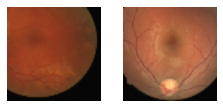

In [33]:
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    #print(sample_images_one[n].numpy().shape)
    plt.axis("off")
plt.show()

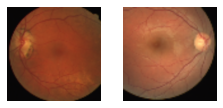

In [34]:
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

In [35]:
def off_diagonal(x):
    n = tf.shape(x)[0]
    flattened = tf.reshape(x, [-1])[:-1]
    off_diagonals = tf.reshape(flattened, (n-1, n+1))[:, 1:]
    return tf.reshape(off_diagonals, [-1])


def normalize_repr(z):
    z_norm = (z - tf.reduce_mean(z, axis=0)) / tf.math.reduce_std(z, axis=0)
    return z_norm


def compute_loss(z_a, z_b, lambd):
    # Get batch size and representation dimension.
    batch_size = tf.cast(tf.shape(z_a)[0], z_a.dtype)
    repr_dim = tf.shape(z_a)[1]

    # Normalize the representations along the batch dimension.
    z_a_norm = normalize_repr(z_a)
    z_b_norm = normalize_repr(z_b)

    # Cross-correlation matrix.
    c = tf.matmul(z_a_norm, z_b_norm, transpose_a=True) / batch_size

    # Loss.
    on_diag = tf.linalg.diag_part(c) + (-1)
    on_diag = tf.reduce_sum(tf.pow(on_diag, 2))
    off_diag = off_diagonal(c)
    off_diag = tf.reduce_sum(tf.pow(off_diag, 2))
    loss = on_diag + (lambd * off_diag)
    return loss 

In [36]:
class BarlowTwins(tf.keras.Model):
    def __init__(self, encoder, lambd=5e-3):
        super(BarlowTwins, self).__init__()
        self.encoder = encoder
        self.lambd = lambd
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z_a, z_b = self.encoder(ds_one, training=True), self.encoder(ds_two, training=True)
            loss = compute_loss(z_a, z_b, self.lambd) 

        # Compute gradients and update the parameters.
        gradients = tape.gradient(loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [37]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Implements an LR scheduler that warms up the learning rate for some training steps
    (usually at the beginning of the training) and then decays it
    with CosineDecay (see https://arxiv.org/abs/1608.03983)
    """

    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [38]:
PROJECT_DIM = IMG_HEIGHT/2
BATCH_SIZE = 8
EPOCHS = 100
WEIGHT_DECAY = 5e-4
TRAIN_FLG = 1 # 0 - No Training, 1 - Training
val_split = 0.3

STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

lr_decayed_fn = WarmUpCosine(
    learning_rate_base=1e-3,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

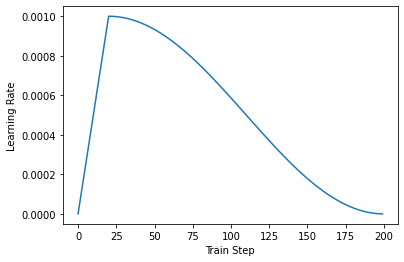

In [39]:
# Visualize the LR schedule
plt.plot(lr_decayed_fn(tf.range(EPOCHS*STEPS_PER_EPOCH, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [40]:
def projection_head(x, hidden_dim=128):
    """Constructs the projection head."""
    for i in range(2):
        x = Dense(
            hidden_dim,
            name=f"projection_layer_{i}",
            kernel_regularizer=l2(WEIGHT_DECAY),
        )(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    outputs = Dense(hidden_dim, name="projection_output")(x)
    return outputs

def build_encoder(shape, hidden_dim=128):
    inputs = Input(shape)
    s = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    #s = inputs
    x, skip_1 = encoder(s)
    
    x = bottleneck(x)
    
    # Projections
    trunk_output = GlobalAvgPool2D()(x)
    projection_outputs = projection_head(trunk_output, hidden_dim=hidden_dim)

    model = Model(inputs, projection_outputs)
    return model, skip_1

In [41]:
unet_enc, skip_connetions = build_encoder((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), hidden_dim=PROJECT_DIM)
unet_enc.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 separable_conv2d_10 (Separable  (None, 256, 256, 16  91         ['rescaling_1[0][0]']            
 Conv2D)                        )                                                                 
                                                                                            

                                                                                                  
 batch_normalization_24 (BatchN  (None, 64, 64, 64)  256         ['separable_conv2d_15[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 64)   2112        ['max_pooling2d_5[0][0]']        
                                                                                                  
 activation_17 (Activation)     (None, 64, 64, 64)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 batch_normalization_25 (BatchN  (None, 64, 64, 64)  256         ['conv2d_7[0][0]']               
 ormalization)                                                                                    
          

 projection_layer_1 (Dense)     (None, 128)          16512       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_33 (BatchN  (None, 128)         512         ['projection_layer_1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 activation_23 (Activation)     (None, 128)          0           ['batch_normalization_33[0][0]'] 
                                                                                                  
 projection_output (Dense)      (None, 128)          16512       ['activation_23[0][0]']          
                                                                                                  
Total params: 255,467
Trainable params: 251,979
Non-trainable params: 3,488
_________________________________

Training
Epoch 1/100
5/5 [==============================] - 10s 839ms/step - loss: 66.1438
Epoch 2/100
5/5 [==============================] - 4s 772ms/step - loss: 48.5257
Epoch 3/100
5/5 [==============================] - 4s 794ms/step - loss: 36.8909
Epoch 4/100
5/5 [==============================] - 4s 792ms/step - loss: 42.2149
Epoch 5/100
5/5 [==============================] - 4s 794ms/step - loss: 35.0118
Epoch 6/100
5/5 [==============================] - 4s 818ms/step - loss: 34.4412
Epoch 7/100
5/5 [==============================] - 4s 800ms/step - loss: 35.3967
Epoch 8/100
5/5 [==============================] - 4s 801ms/step - loss: 33.6697
Epoch 9/100
5/5 [==============================] - 4s 820ms/step - loss: 32.6727
Epoch 10/100
5/5 [==============================] - 4s 806ms/step - loss: 30.6775
Epoch 11/100
5/5 [==============================] - 4s 820ms/step - loss: 34.8553
Epoch 12/100
5/5 [==============================] - 4s 783ms/step - loss: 34.9892
Epoch 13/100
5/

INFO:tensorflow:Assets written to: barlow_twins_unet\assets


INFO:tensorflow:Assets written to: barlow_twins_unet\assets


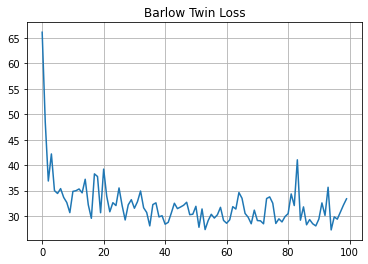

In [42]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
barlow_twins = BarlowTwins(unet_enc)
barlow_twins.compile(optimizer=optimizer)
if TRAIN_FLG:
    print("Training")
    barlow_twins.encoder.get_weights()[0]
    history = barlow_twins.fit(ssl_ds, epochs=EPOCHS)
    barlow_twins.encoder.save('barlow_twins_unet')
    plt.plot(history.history["loss"])
    plt.grid()
    plt.title("Barlow Twin Loss")
    plt.show()
elif not TRAIN_FLG:
    print("Loading training weights")
    barlow_twins.encoder.load_weights('barlow_twins_unet')

In [43]:
backbone = tf.keras.Model(
    barlow_twins.encoder.input, barlow_twins.encoder.layers[-9].output
)
backbone.layers

In [44]:
backbone.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 separable_conv2d_10 (Separable  (None, 256, 256, 16  91         ['rescaling_1[0][0]']            
 Conv2D)                        )                                                                 
                                                                                            

                                                                                                  
 batch_normalization_24 (BatchN  (None, 64, 64, 64)  256         ['separable_conv2d_15[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 64)   2112        ['max_pooling2d_5[0][0]']        
                                                                                                  
 activation_17 (Activation)     (None, 64, 64, 64)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 batch_normalization_25 (BatchN  (None, 64, 64, 64)  256         ['conv2d_7[0][0]']               
 ormalization)                                                                                    
          

In [45]:
new_skip_connections = [backbone.get_layer(index=11).output, 
                        backbone.get_layer(index=22).output, 
                        backbone.get_layer(index=33).output, 
                        backbone.get_layer(index=44).output]

In [46]:
new_skip_connections

[<KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'add_5')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'add_6')>,
 <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'add_7')>,
 <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'add_8')>]

In [47]:
backbone.output

<KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by layer 'add_9')>

In [48]:
backbone.trainable=True
x = backbone.output
#x = bottleneck(x)
x = decoder(x, new_skip_connections)
outputs = output(x)
model = Model(barlow_twins.encoder.input, outputs)

In [49]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 separable_conv2d_10 (Separable  (None, 256, 256, 16  91         ['rescaling_1[0][0]']            
 Conv2D)                        )                                                                 
                                                                                            

                                                                                                  
 batch_normalization_24 (BatchN  (None, 64, 64, 64)  256         ['separable_conv2d_15[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 64)   2112        ['max_pooling2d_5[0][0]']        
                                                                                                  
 activation_17 (Activation)     (None, 64, 64, 64)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 batch_normalization_25 (BatchN  (None, 64, 64, 64)  256         ['conv2d_7[0][0]']               
 ormalization)                                                                                    
          

 activation_24 (Activation)     (None, 32, 32, 128)  0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 separable_conv2d_21 (Separable  (None, 32, 32, 128)  17664      ['activation_24[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_35 (BatchN  (None, 32, 32, 128)  512        ['separable_conv2d_21[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 128)  49280       ['concatenate[0][0]']            
                                                                                                  
 activatio

                                                                                                  
 add_12 (Add)                   (None, 128, 128, 32  0           ['batch_normalization_42[0][0]', 
                                )                                 'dropout_12[0][0]']             
                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 256, 256, 32  0          ['add_12[0][0]']                 
                                )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 48  0           ['up_sampling2d_3[0][0]',        
                                )                                 'add_5[0][0]']                  
                                                                                                  
 separable

In [50]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    #print('IOU {}'.format(iou))
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    value = 0.
    for batch in range(batch_size):
        value = value + iou_metric(y_true_in[batch], y_pred_in[batch])
    return value/batch_size

def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

def my_iou_metric_loss(label, pred):
    loss = 1-tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    #loss = -tf.map_fn(my_iou_metric_loss(label, pred), tf.range(tf.shape(pred)[0]))
    loss.set_shape((None,))

    return loss

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def haud_dist(y_true, y_pred):
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    
    return hausdorff_distance(y_true,y_pred)

def haud_dist_batch(y_true, y_pred):
    if len(y_true.shape)==2:
        return haud_dist(y_true, y_pred)
    else:
        batch_size = y_true.shape[0]
    hd = 0.
    for batch in range(batch_size):
        hd = hd + haud_dist(y_true[batch], y_pred[batch])
    return hd/batch_size

def my_haud_dist(label, pred):
    metric_value = tf.py_function(haud_dist_batch, [label, pred], tf.float32)
    return metric_value

def evalResult(gt,pred,target_size=(256,256),flag_multi_class = False,num_class = 2):
    gt = np.squeeze(gt)
    pred = np.squeeze(pred)
    
    acc = Accuracy()
    acc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_acc = acc.result().numpy()
    
    pr = Precision()
    pr.update_state(np.squeeze(gt), np.squeeze(pred))
    r_pr = pr.result().numpy()
    
    rc = Recall()
    rc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_rc = rc.result().numpy()
    
    mi = MeanIoU(num_class)
    mi.update_state(np.squeeze(gt), np.squeeze(pred))
    r_mi = mi.result().numpy()
    
    dc = 0.
    for img in range(gt.shape[0]):
        dc = dc + dice_coeff(gt[img], pred[img]).numpy()
    dc = dc / gt.shape[0]
    
    hd = haud_dist_batch(gt,pred)
    
    miou = iou_metric_batch(gt,pred)
    
    mae = MeanAbsoluteError()
    r_mae = mae(np.squeeze(gt), np.squeeze(pred)).numpy()

    print("Accuracy=",r_acc, "Precision=",r_pr, "Recall=",r_rc, "MeanIoU=",r_mi, "DiceCoefficient=",dc, "HD=",hd, "MyIoU=",miou, "MAE=",r_mae)

In [51]:
def focal_loss(target_tensor, prediction_tensor, weights=None, alpha=0.25, gamma=2):
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.math.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0))                           - (1 - alpha) * (neg_p_sub ** gamma) * tf.math.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

def mean_iou_loss(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return -tf.math.log(K.mean(K.stack(prec), axis=0))

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.4*categorical_crossentropy(y_true, y_pred) + 0.6*dice_loss(y_true, y_pred)
    return loss

def bce_dice_loss2(y_true, y_pred):
    fl = focal_loss(y_true, y_pred, gamma=5)
    loss = 0.2*categorical_crossentropy(y_true, y_pred) + 0.3*dice_loss(y_true, y_pred) + 0.5*fl
    return loss

In [52]:
log_path = "logs/"
keyname = "BT-Unet"
cur_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_log_dir = log_path + "fit/" + keyname + '_' + cur_date 
tensorboard_callback = TensorBoard(log_dir=tb_log_dir, histogram_freq=0)
model_checkpoint = ModelCheckpoint('model_'+keyname+'.hdf5', monitor='loss',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', verbose=1, patience=20)
csv_logger = CSVLogger(log_path + keyname + '_' + cur_date + '.log', separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

In [53]:
model.compile(
    loss=bce_dice_loss,
    optimizer=Adam(),
    metrics=['accuracy', Precision(), MeanIoU(num_classes=2), Recall(), dice_coeff, MeanAbsoluteError(), my_haud_dist, my_iou_metric]
   )
if TRAIN_FLG:
    print("Training")
    callbacks = [
        model_checkpoint,
        reduce_lr,
        csv_logger,
        tensorboard_callback,
        early_stopping
    ]
    X_train_20 = X_train[:int(X_train.shape[0]*0.2)]
    Y_train_20 = Y_train[:int(Y_train.shape[0]*0.2)]
    results = model.fit(X_train_20, Y_train_20, validation_split=val_split, batch_size=8, epochs=200, callbacks=callbacks)
elif not TRAIN_FLG:
    print("Loading training weights")
    model.load_weights('model_'+keyname+'.hdf5')

Training
Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.4617 - precision: 0.6544 - mean_io_u: 0.1466 - recall: 0.5049 - dice_coeff: 0.5651 - mean_absolute_error: 0.5273 - my_haud_dist: 8.3879 - my_iou_metric: 7.3260e-04
Epoch 1: loss improved from inf to 0.26094, saving model to model_BT-Unet.hdf5
1/1 [==============================] - 17s 17s/step - loss: 0.2609 - accuracy: 0.4617 - precision: 0.6544 - mean_io_u: 0.1466 - recall: 0.5049 - dice_coeff: 0.5651 - mean_absolute_error: 0.5273 - my_haud_dist: 8.3879 - my_iou_metric: 7.3260e-04 - val_loss: 0.4230 - val_accuracy: 0.3158 - val_precision: 0.7672 - val_mean_io_u: 0.1446 - val_recall: 0.0536 - val_dice_coeff: 0.2950 - val_mean_absolute_error: 0.6487 - val_my_haud_dist: 10.2161 - val_my_iou_metric: 0.0000e+00 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.1697 - accuracy: 0.8487 - precision: 0.9867 - mean_io_u: 0.1466 - recall: 0.7967 - dice_coeff: 0.7172 -

1/1 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9703 - precision: 0.9999 - mean_io_u: 0.1466 - recall: 0.9580 - dice_coeff: 0.7498 - mean_absolute_error: 0.3046 - my_haud_dist: 5.7647 - my_iou_metric: 0.0450
Epoch 11: loss improved from 0.15039 to 0.15010, saving model to model_BT-Unet.hdf5
1/1 [==============================] - 1s 1s/step - loss: 0.1501 - accuracy: 0.9703 - precision: 0.9999 - mean_io_u: 0.1466 - recall: 0.9580 - dice_coeff: 0.7498 - mean_absolute_error: 0.3046 - my_haud_dist: 5.7647 - my_iou_metric: 0.0450 - val_loss: 0.0265 - val_accuracy: 0.9484 - val_precision: 0.9994 - val_mean_io_u: 0.1446 - val_recall: 0.9279 - val_dice_coeff: 0.9558 - val_mean_absolute_error: 0.0602 - val_my_haud_dist: 3.2259 - val_my_iou_metric: 0.0771 - lr: 0.0010
Epoch 12/200
1/1 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.9709 - precision: 0.9999 - mean_io_u: 0.1466 - recall: 0.9589 - dice_coeff: 0.7503 - mean_absolute_error: 0.3040 -

1/1 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.9750 - precision: 1.0000 - mean_io_u: 0.1466 - recall: 0.9647 - dice_coeff: 0.7521 - mean_absolute_error: 0.3016 - my_haud_dist: 5.7097 - my_iou_metric: 0.1548
Epoch 21: loss improved from 0.14885 to 0.14877, saving model to model_BT-Unet.hdf5
1/1 [==============================] - 1s 1s/step - loss: 0.1488 - accuracy: 0.9750 - precision: 1.0000 - mean_io_u: 0.1466 - recall: 0.9647 - dice_coeff: 0.7521 - mean_absolute_error: 0.3016 - my_haud_dist: 5.7097 - my_iou_metric: 0.1548 - val_loss: 0.0329 - val_accuracy: 0.9518 - val_precision: 0.9995 - val_mean_io_u: 0.1446 - val_recall: 0.9327 - val_dice_coeff: 0.9451 - val_mean_absolute_error: 0.0741 - val_my_haud_dist: 3.1497 - val_my_iou_metric: 0.0825 - lr: 1.0000e-04
Epoch 22/200
1/1 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9753 - precision: 1.0000 - mean_io_u: 0.1466 - recall: 0.9651 - dice_coeff: 0.7521 - mean_absolute_error: 0.30

1/1 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9762 - precision: 1.0000 - mean_io_u: 0.1466 - recall: 0.9663 - dice_coeff: 0.7522 - mean_absolute_error: 0.3014 - my_haud_dist: 5.6935 - my_iou_metric: 0.1458
Epoch 31: loss did not improve from 0.14866
1/1 [==============================] - 1s 901ms/step - loss: 0.1487 - accuracy: 0.9762 - precision: 1.0000 - mean_io_u: 0.1466 - recall: 0.9663 - dice_coeff: 0.7522 - mean_absolute_error: 0.3014 - my_haud_dist: 5.6935 - my_iou_metric: 0.1458 - val_loss: 0.0556 - val_accuracy: 0.9518 - val_precision: 1.0000 - val_mean_io_u: 0.1446 - val_recall: 0.9322 - val_dice_coeff: 0.9073 - val_mean_absolute_error: 0.1209 - val_my_haud_dist: 3.1933 - val_my_iou_metric: 0.0818 - lr: 1.0000e-05
Epoch 32/200
1/1 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.9763 - precision: 1.0000 - mean_io_u: 0.1466 - recall: 0.9664 - dice_coeff: 0.7523 - mean_absolute_error: 0.3013 - my_haud_dist: 5.7249 - my_iou_me

Epoch 42/200
1/1 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9762 - precision: 1.0000 - mean_io_u: 0.1466 - recall: 0.9664 - dice_coeff: 0.7522 - mean_absolute_error: 0.3013 - my_haud_dist: 5.6553 - my_iou_metric: 0.1214
Epoch 42: loss did not improve from 0.14862
1/1 [==============================] - 1s 954ms/step - loss: 0.1487 - accuracy: 0.9762 - precision: 1.0000 - mean_io_u: 0.1466 - recall: 0.9664 - dice_coeff: 0.7522 - mean_absolute_error: 0.3013 - my_haud_dist: 5.6553 - my_iou_metric: 0.1214 - val_loss: 0.0841 - val_accuracy: 0.9514 - val_precision: 1.0000 - val_mean_io_u: 0.1446 - val_recall: 0.9316 - val_dice_coeff: 0.8598 - val_mean_absolute_error: 0.1760 - val_my_haud_dist: 4.0119 - val_my_iou_metric: 0.0796 - lr: 1.0000e-06
Epoch 43/200
1/1 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.9765 - precision: 1.0000 - mean_io_u: 0.1466 - recall: 0.9667 - dice_coeff: 0.7523 - mean_absolute_error: 0.3012 - my_haud_dist: 5.709

Epoch 53/200
1/1 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9761 - precision: 1.0000 - mean_io_u: 0.1466 - recall: 0.9662 - dice_coeff: 0.7522 - mean_absolute_error: 0.3013 - my_haud_dist: 5.7306 - my_iou_metric: 0.2083
Epoch 53: loss did not improve from 0.14860
1/1 [==============================] - 1s 933ms/step - loss: 0.1487 - accuracy: 0.9761 - precision: 1.0000 - mean_io_u: 0.1466 - recall: 0.9662 - dice_coeff: 0.7522 - mean_absolute_error: 0.3013 - my_haud_dist: 5.7306 - my_iou_metric: 0.2083 - val_loss: 0.1086 - val_accuracy: 0.9510 - val_precision: 1.0000 - val_mean_io_u: 0.1446 - val_recall: 0.9310 - val_dice_coeff: 0.8191 - val_mean_absolute_error: 0.2210 - val_my_haud_dist: 4.7624 - val_my_iou_metric: 0.0859 - lr: 1.0000e-07
Epoch 54/200
1/1 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9760 - precision: 1.0000 - mean_io_u: 0.1466 - recall: 0.9661 - dice_coeff: 0.7522 - mean_absolute_error: 0.3014 - my_haud_dist: 5.718

Epoch 64/200
1/1 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.9761 - precision: 1.0000 - mean_io_u: 0.1466 - recall: 0.9661 - dice_coeff: 0.7523 - mean_absolute_error: 0.3013 - my_haud_dist: 5.6929 - my_iou_metric: 0.1714
Epoch 64: loss did not improve from 0.14860
1/1 [==============================] - 1s 934ms/step - loss: 0.1486 - accuracy: 0.9761 - precision: 1.0000 - mean_io_u: 0.1466 - recall: 0.9661 - dice_coeff: 0.7523 - mean_absolute_error: 0.3013 - my_haud_dist: 5.6929 - my_iou_metric: 0.1714 - val_loss: 0.1277 - val_accuracy: 0.9507 - val_precision: 1.0000 - val_mean_io_u: 0.1446 - val_recall: 0.9306 - val_dice_coeff: 0.7871 - val_mean_absolute_error: 0.2555 - val_my_haud_dist: 5.3276 - val_my_iou_metric: 0.0825 - lr: 1.0000e-08
Epoch 65/200
1/1 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.9762 - precision: 1.0000 - mean_io_u: 0.1466 - recall: 0.9663 - dice_coeff: 0.7523 - mean_absolute_error: 0.3013 - my_haud_dist: 5.660

In [54]:
preds_train = model.predict(X_train_20[:int(X_train_20.shape[0]*(1-val_split))], verbose=1)
preds_x = model.predict(X_train, verbose=1)
preds_val = model.predict(X_train_20[int(X_train_20.shape[0]*(1-val_split)):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

gt_train = Y_train_20[:int(X_train_20.shape[0]*(1-val_split))].astype(np.float32)
gt_x = Y_train.astype(np.float32)
gt_val = Y_train_20[int(X_train.shape[0]*(1-val_split)):].astype(np.float32)
gt_test = Y_test.astype(np.float32)

1/1 [==============================] - 1s 1s/step


In [55]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_x_t = (preds_x > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)

In [65]:
evalResult(gt_train, preds_train_t)

Accuracy= 0.92276 Precision= 1.0 Recall= 0.89070493 MeanIoU= 0.84112316 DiceCoefficient= 0.940974622964859 HD= 5.232050807568877 MyIoU= 0.08774509803921568 MAE= 0.07723999


In [58]:
evalResult(gt_val, preds_val_t)


ValueError: Shapes (0, 256, 256) and (2, 256, 256) are incompatible

In [59]:
evalResult(gt_x, preds_x_t)

Accuracy= 0.77414244 Precision= 1.0 Recall= 0.68097097 MeanIoU= 0.62243617 DiceCoefficient= 0.7500438447110355 HD= 7.385487056133002 MyIoU= 0.056174687183991455 MAE= 0.22585754


In [60]:
evalResult(gt_test, preds_test_t)

Accuracy= 0.804422 Precision= 1.0 Recall= 0.7235613 MeanIoU= 0.6614289 DiceCoefficient= 0.7927956612315029 HD= 6.760474063366274 MyIoU= 0.11259957942121131 MAE= 0.19557801


IndexError: index 14 is out of bounds for axis 0 with size 14

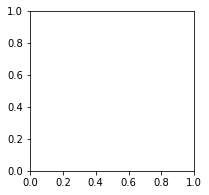

In [64]:
x=0
xx = [14,10,15]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_train[:int(X_train.shape[0]*(1-val_split))][ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_train_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix], preds_train_t[ix])
    x = x+3

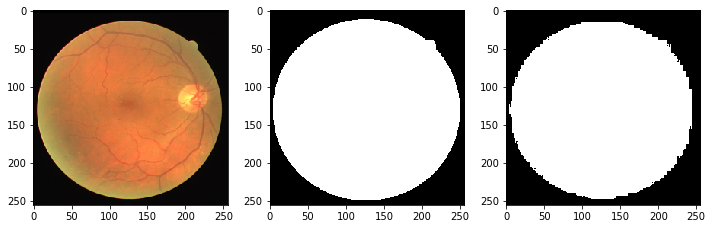

Accuracy= 0.968338 Precision= 1.0 Recall= 0.95505255 MeanIoU= 0.929149 DiceCoefficient= 0.9518337189292652 HD= 3.0 MyIoU= 0.75703125 MAE= 0.031661987


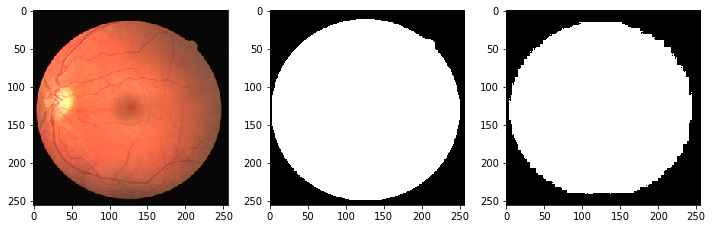

Accuracy= 0.9499359 Precision= 1.0 Recall= 0.9295318 MeanIoU= 0.8910588 DiceCoefficient= 0.918582388861978 HD= 5.0 MyIoU= 0.7203776041666671 MAE= 0.050064087


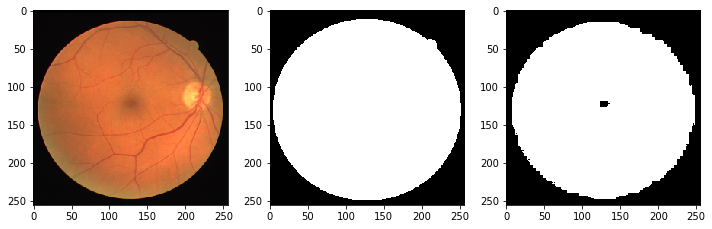

Accuracy= 0.95402527 Precision= 1.0 Recall= 0.935228 MeanIoU= 0.8992362 DiceCoefficient= 0.9390134294662857 HD= 3.605551275463989 MyIoU= 0.7385416666666672 MAE= 0.04597473


In [62]:
x=0
xx = [16,10,15]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_test[ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_test[ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_test_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_test[ix], preds_test_t[ix])
    x = x+3
